In [ ]:
# read in patient key
root = UF.DataRoot(2)
LimbusKey = pd.read_csv(root + "\\Aaron\\ProstateMRL\\Code\\Extraction\\PatKeys\\LimbusKey.csv")
AllKey = pd.read_csv(root + "\\Aaron\\ProstateMRL\\Code\\Extraction\\PatKeys\\AllPatientKey_s.csv")

# Loop through treatments
treatments = AllKey["Treatment"].unique()
new_key = pd.DataFrame()
for t in treatments:
    AllKey_t = AllKey[AllKey["Treatment"] == t]
    LimbusKey_t = LimbusKey[LimbusKey["Treatment"] == t]

    # Loop through patients
    patIDs = LimbusKey_t["PatID"].unique()

    for pat in patIDs:
        pat_L = LimbusKey_t[LimbusKey_t["PatID"] == pat]
        pat_A = AllKey_t[AllKey_t["PatID"] == pat]
        print(pat_A)
        print(pat_L)
        # add date and days column from all to limbus key based on Scan
        for i in range(len(pat_L)):
            scan = pat_L.iloc[i]["Scan"]
            fraction = pat_A.iloc[i]["Fraction"]
            date = pat_A[pat_A["Scan"] == scan]["Date"].values[0]
            days = pat_A[pat_A["Scan"] == scan]["Days"].values[0]
            pat_L.at[pat_L.index[i], "Date"] = str(date)
            pat_L.at[pat_L.index[i], "Days"] = int(days)
            pat_L.at[pat_L.index[i], "Fraction"] = int(fraction)

        pat_L["Days"] = pat_L["Days"].astype(int)
        # sort by days
        pat_L = pat_L.sort_values(by=["Fraction"])

    # add to new key
        new_key = new_key.append(pat_L)

new_key.to_csv(root + "\\Aaron\\ProstateMRL\\Code\\Extraction\\PatKeys\\LimbusKey_s.csv", index=False)


        
        



In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

csvs = os.listdir("E:\\Aaron\ProstateMRL\Data\Paper1\HM-FSTP\\Longitudinal\ClusterLabels\\")
#csvs = [csv for csv in csvs if "HM" in csv]

fts_s = pd.read_csv("E:\\Aaron\ProstateMRL\Data\Paper1\\HM-FSTP\\Features\\SelectedFeatures_Longitudinal.csv")
fts_s = fts_s["Feature"].values
for csv in csvs:
    df = pd.read_csv("E:\\Aaron\ProstateMRL\Data\Paper1\\HM-FSTP\\Longitudinal\ClusterLabels\\" + csv)
    pat = str(csv)[:-4]
    df["Selected"] = df["Feature"].apply(lambda x: x in fts_s)
    # print where selected is True
    df = df[['Feature', 'Cluster', 'Fraction', 'FeatureChange', 'Selected']]
    df['Feature'] = df['Feature'].str.replace('original_', '')
    clusters = df["Cluster"].unique()
    clusters = sorted(clusters, key=lambda x: int(x))
    for c in clusters:
        df_c = df[df["Cluster"] == c]
        df_c = df_c.sort_values(by = ["Fraction"])

        # get selected features
        selected_fts = df_c[df_c["Selected"] == True]["Feature"].unique()
        if len(selected_fts) == 0:
            sf_str = "No features selected"
        
        number_fts = "Total number of feature(s) in Cluster {}: {}\nNumber of selected features: {}\n".format(c, df_c["Feature"].nunique(), len(selected_fts) )
        text_str = selected_fts
        text_str = '\n'.join(text_str)
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
        fts = df_c["Feature"].values
        plt.figure(figsize=(10, 10))
        plt.title(" Cluster " + str(c))
        sns.set_theme(style="whitegrid")
        sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
        for ft in fts:
            df_ft = df_c[df_c["Feature"] == ft]
            values = df_ft["FeatureChange"].values
            fractions = df_ft["Fraction"].values
            colour = "blue" if df_ft["Selected"].values[0] else "grey"
            l = df_ft["Feature"].values[0]
            plt.plot(fractions, values, label = l, color = colour)
            #plt.scatter(fractions, values, color = colour)
        plt.xlabel("Fraction", fontsize = 20)
        plt.ylabel("Feature Change", fontsize = 20)
        plt.xticks(np.arange(1, 5.1, 1))
        plt.xlim(1, 5)
        #plt.ylim(-1, 1)
        # add text box
        #plt.text(0.05, 0.95, (number_fts + text_str), transform=plt.gca().transAxes, fontsize=14, verticalalignment='top', bbox=props)
        
        #plt.legend(title = "Feature Selected", bbox_to_anchor=(1, 0.6), labels = ["Yes", "No"])
        plt.title("Cluster " + str(c), fontsize = 30)
        plt.savefig("E:\\Aaron\ProstateMRL\Data\Paper1\HM-FSTP\Longitudinal\ClusterPlots\\Run2_" + str(pat) + "_Cluster" + str(c) + ".png", bbox_inches = "tight")
        #plt.show()
        plt.close()






In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

dir = "E:\\Aaron\\ProstateMRL\\Data\\Paper1\\NormSummary\\"

files = os.listdir(dir)

result = pd.DataFrame()

for file in files:
    # loop through txt files and get lines that contain Before:
    with open(dir + file, "r") as f:
        lines = f.readlines()
        # filter so only lines with Before: are kept
        # get line with 
        lines = [line for line in lines if "Longitudinal" in line]

        r_lines = [line for line in lines if "Removed:" in line]
        s_line = [line for line in lines if "Selected:" in line]
        
        ICC = int(r_lines[0][-3:])
        Vol = int(r_lines[1][-3:])
        Sel = int(s_line[0][-3:])

        result = result.append({"Norm": file[:-4], "ICC": ICC, "Volume": Vol, "Selected": Sel}, ignore_index=True) 
result = result.melt(id_vars=["Norm"], var_name="Stage", value_name="Number")

# order result so plot is in correct order
result["Norm"] = pd.Categorical(result["Norm"], ["Raw", "HM-FS", "HM-TP", "HM-FSTP", "Med-Pros", "Med-Psoas"])
result["Stage"] = pd.Categorical(result["Stage"], ["ICC", "Volume", "Selected"])

# bar plot results
plt.figure(figsize=(10, 10))
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.barplot(x="Norm", y="Number", data=result, hue="Stage")
plt.xlabel("Normalisation", fontsize = 20)
plt.ylabel("Number of Features", fontsize = 20)
plt.title("Number of Features Removed or Selected", fontsize = 26)



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_csv("E:\\Aaron\ProstateMRL\Code\PatKeys\\MedianSignalNorm.csv")
df = df.drop(columns=["Unnamed: 0"])

# pick a random patient
pat = df["PatID"].sample().values[0]

# change Mask variables to Prostate and Psoas
df["Mask"] = df["Mask"].apply(lambda x: "Prostate" if x == "shrunk_pros" else "Psoas")
df = df[df["PatID"] == pat]
# plot signal over time for each normalisation in facet grid
g = sns.FacetGrid(df, col="Norm", hue="Mask", col_wrap=3, height=5, aspect=1.5)
g.map(sns.lineplot, "Scan", "Median", marker="o")
g.set_axis_labels("Fraction", "Median Signal")
g.set_titles("{col_name}")
g.add_legend()
plt.suptitle("Median Signal for Patient " + str(pat), fontsize = 30)
plt.subplots_adjust(top=0.9)
plt.show()



In [21]:
import pandas as pd
from sklearn import preprocessing
from tqdm import tqdm
root = "E:\\"
Norm = "HM-FS"

df_all = pd.read_csv(root + "Aaron\ProstateMRL\Data\Paper1\\" + Norm + "\\Features\\Longitudinal_All_fts.csv")
# remove minimum feature
df_all = df_all[df_all["Feature"] != "original_firstorder_Minimum"]

df_all["FeatureRS11"] = 0
df_all["FeatureRS01"] = 0
df_all["FeatureChangeRS11"] = 0
df_all["FeatureChangeRS01"] = 0
for pat in tqdm(df_all["PatID"].unique()):
    for ft in df_all["Feature"].unique():
        ft_vals = df_all[df_all["Feature"] == ft]["FeatureValue"].values
        ft_vals11 = preprocessing.minmax_scale(ft_vals, feature_range=(-1, 1))
        ft_vals01 = preprocessing.minmax_scale(ft_vals, feature_range=(0, 1))
        df_all.loc[df_all["Feature"] == ft, "FeatureRS11"] = ft_vals11
        df_all.loc[df_all["Feature"] == ft, "FeatureRS01"] = ft_vals01

        ft_change = (ft_vals - ft_vals[0]) / ft_vals[0]
        ft_change11 = preprocessing.minmax_scale(ft_change, feature_range=(-1, 1))
        ft_change01 = preprocessing.minmax_scale(ft_change, feature_range=(0, 1))
        df_all.loc[df_all["Feature"] == ft, "FeatureChangeRS11"] = ft_change11
        df_all.loc[df_all["Feature"] == ft, "FeatureChangeRS01"] = ft_change01


# pivot table so feature values and changes are in columns
# plot features over time for each patient in facet grid


    

100%|██████████| 20/20 [00:08<00:00,  2.27it/s]


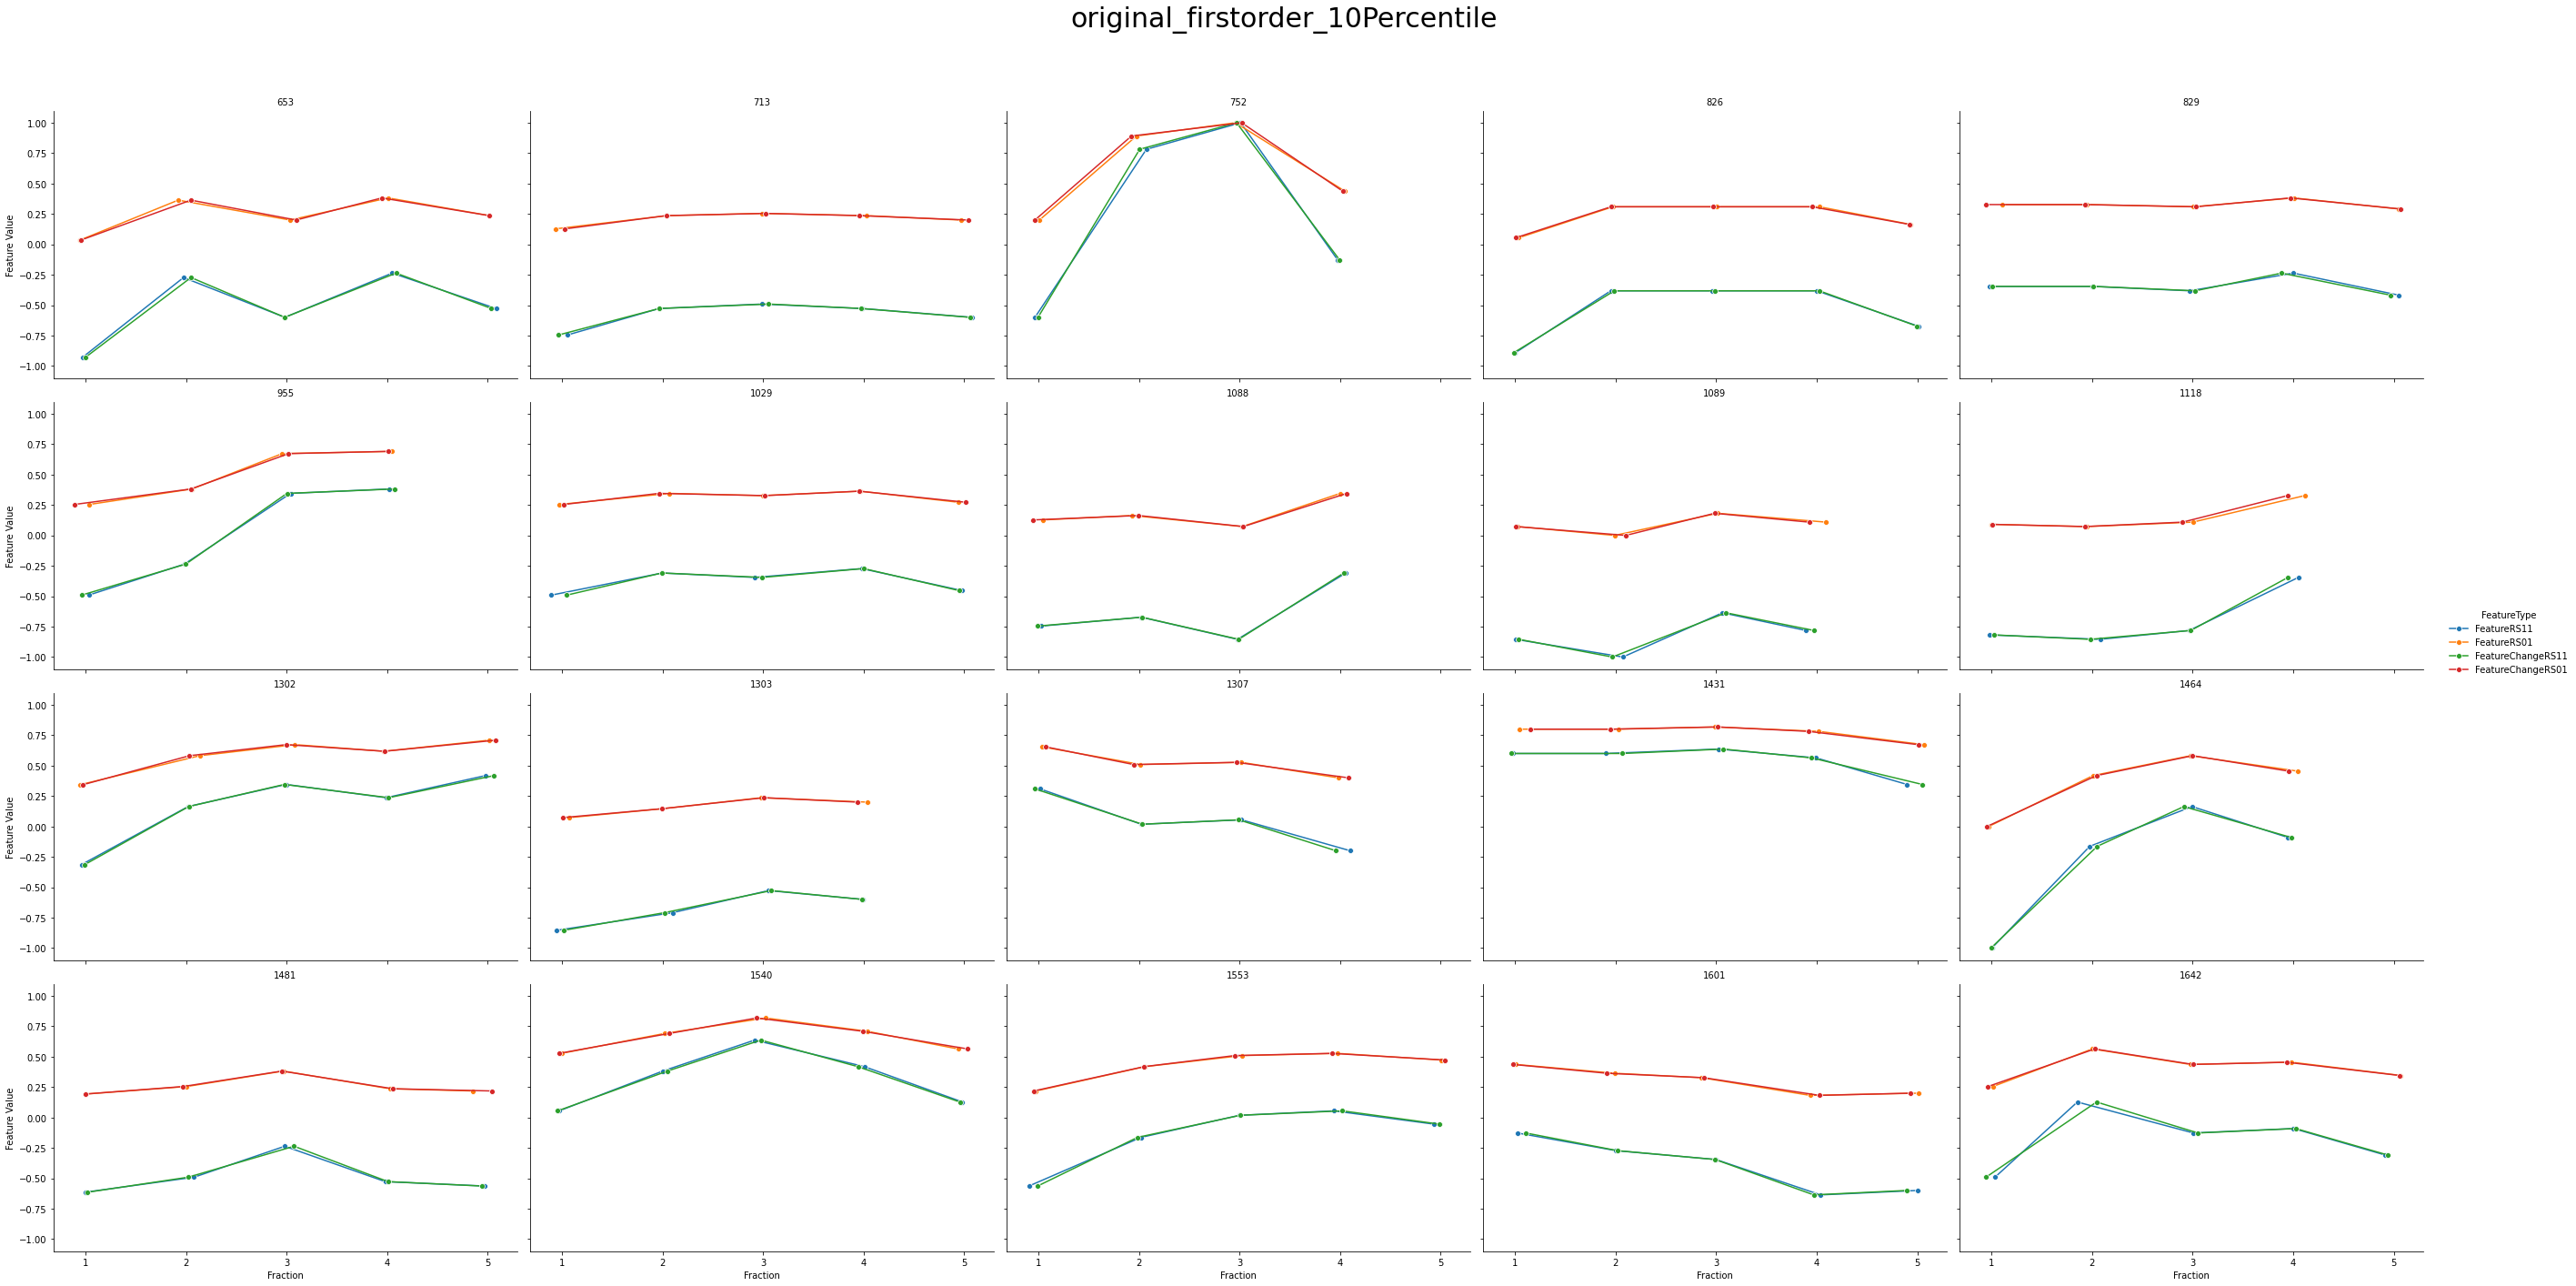

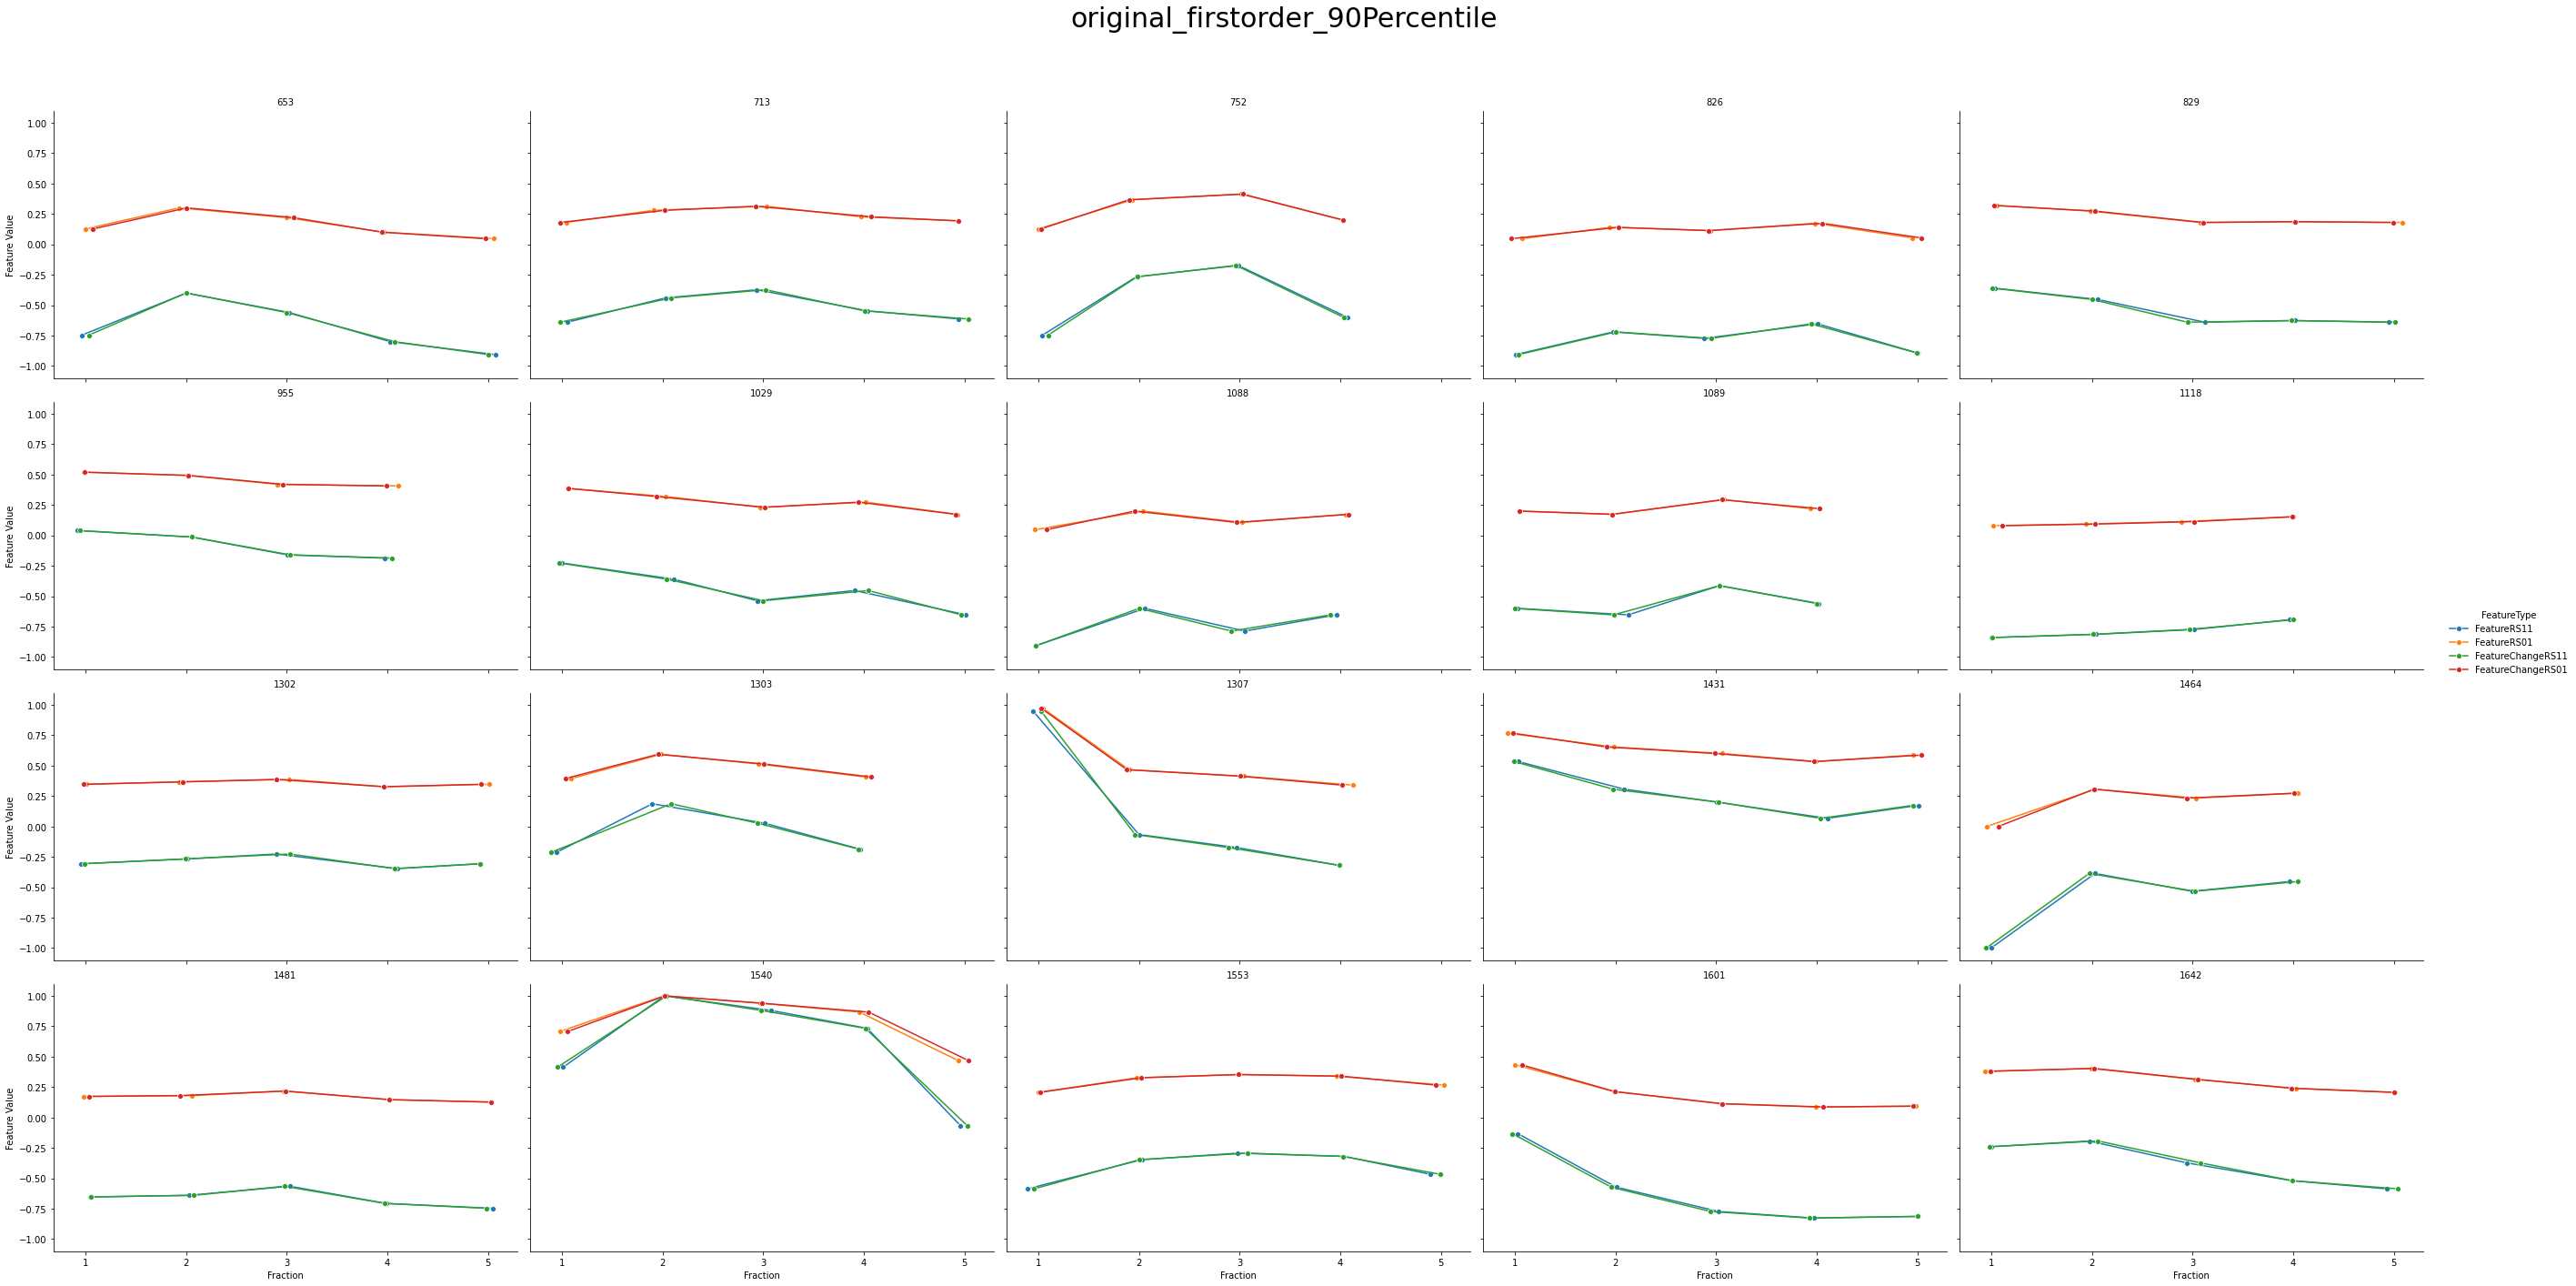

KeyboardInterrupt: 

In [41]:
# pivot df long 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


df_l = df_all.melt(id_vars=["PatID", "Scan", "Mask", "Fraction", "Days", "Feature"], var_name="FeatureType", value_name="Value")

df_l = df_l[df_l["FeatureType"].isin(["FeatureRS11", "FeatureRS01", "FeatureChangeRS11", "FeatureChangeRS01"])]
# add small random noise to fraction to avoid overlapping points
df_l["Fraction"] = df_l["Fraction"] + np.random.normal(0, 0.05, df_l.shape[0])

# plot features over time for each patient in facet grid
for ft in df_l["Feature"].unique()[0:10]:
    df_l_ft = df_l[df_l["Feature"] == ft]
    g = sns.FacetGrid(df_l_ft, col="PatID", hue="FeatureType", col_wrap=5, height=5, aspect=1.5)
    g.map(sns.lineplot, "Fraction", "Value", marker="o")
    g.set_axis_labels("Fraction", "Feature Value")
    g.set_titles("{col_name}")
    g.add_legend()
    plt.suptitle(ft, fontsize = 30)
    plt.subplots_adjust(top=0.9)
    plt.show()
    plt.close()

